In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.exceptions import ConvergenceWarning
import warnings
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import sys
sys.path.append('../../')
from dataset import Dataset
from xgboost import XGBRegressor, plot_importance


In [4]:
data = Dataset('15min')
data = data.preprocess()

/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Estimation/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Estimation/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Estimation/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Estimation/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x =

In [60]:
data = pd.read_csv("/home/stelios-pc/Desktop/PhD/HALCOR/Data/data.csv")
data.drop(columns=['Unnamed: 0','Real Energy', 'Duration (min)', 'Timestamp'], inplace=True)
target_feature = data['diff']
data.drop(columns = ['diff'], inplace = True)
data

,Product Group,SKU code,Event Code_plc,Duration (sec),Καθαρές Μηχανοώρες (min),Work Center,Event Code_mes,Production Quantity (#),DB 955DBW 8 in die side,DB 955DBW 12 in center,...,DB 2000DBW 56 man counter,DB 700DBW 46 contener counter,DB 301DBW 272 cooling water mandrel outlet,DB 301DBW 274 cooling water mandrel inlet,DB 301DBW 276 mandrel coolng flow,DB 301DBW 96 mandrell movment,DB 30DBW 80 contener position,DB 10DBW 114 cont cooling air flow,MW 46 mikos bigetas,DB 301DBW 166 mikos solinas
0,{'DB3'},{'1.0'},{'98.0'},105.0,34.216667,"{'S_DAN2', 'S_DAN1'}","{'70.0', '99.0', '0.0'}",3.0,505.669951,482.032020,...,525.674877,2047.674877,66.482759,59.000000,169.118227,61.586207,14.746305,480.435961,816.012315,305.019704
1,{'DB3'},{'1.0'},{'98.0'},105.0,34.216667,{'S_DAN2'},{'99.0'},3.0,505.669951,482.032020,...,525.674877,2047.674877,66.482759,59.000000,169.118227,61.586207,14.746305,480.435961,816.012315,305.019704
2,{'DB3'},{'1.0'},{'99.0'},2053.0,34.216667,{'S_SCH4B'},{'99.0'},23.0,505.669951,482.032020,...,525.674877,2047.674877,66.482759,59.000000,169.118227,61.586207,14.746305,480.435961,816.012315,305.019704
3,{'DB3'},{'1.0'},"{'98.0', '901.0'}",465.0,34.216667,"{'S_DAN2', 'S_DAN1'}",{'70.0'},24.0,505.669951,482.032020,...,525.674877,2047.674877,66.482759,59.000000,169.118227,61.586207,14.746305,480.435961,816.012315,305.019704
4,{'DB3'},{'1.0'},"{'98.0', '99.0'}",1505.0,21.283333,"{'S_DAN2', 'S_DAN1'}","{'70.0', '99.0'}",18.0,505.669951,482.032020,...,525.674877,2047.674877,66.482759,59.000000,169.118227,61.586207,14.746305,480.435961,816.012315,305.019704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,{'DB3'},{'1.0'},"{'710.0', '98.0', '99.0'}",2535.0,33.650000,"{'S_DAN2', 'S_DAN1'}",{'99.0'},57.0,447.102421,445.853507,...,195.448169,20924.445065,72.493482,64.900683,136.266915,90.662942,18.857852,559.311608,816.453755,306.297952
8732,{'DB3'},{'1.0'},"{'710.0', '98.0', '99.0'}",2535.0,33.650000,"{'S_DAN2', 'S_DAN1'}",{'70.0'},15.0,446.743494,445.048947,...,205.193928,20934.192069,72.586741,65.227385,135.926890,82.420694,17.028501,524.947336,817.416976,308.266419
8733,{'DB3'},{'1.0'},"{'98.0', '99.0', '901.0'}",3843.0,56.266667,{'S_SCH4B'},{'70.0'},79.0,438.202008,443.705772,...,211.000627,20940.000000,68.363237,64.203890,128.633626,82.376412,61.998745,331.196989,818.000000,308.897114
8734,{'DB3'},{'1.0'},"{'98.0', '99.0', '901.0'}",3843.0,56.266667,{'S_SCH4B'},{'70.0'},79.0,429.424686,430.368201,...,212.000000,20941.000000,62.031381,60.458159,128.633626,85.000000,456.000000,104.857741,818.000000,306.000000


In [61]:
data['Product Group'] = data['Product Group'].apply(lambda x: str(x))
data['Product Group'] = pd.Categorical(data['Product Group'])
data['SKU code'] = data['SKU code'].apply(lambda x: str(x))
data['SKU code'] = pd.Categorical(data['SKU code'])
data['Event Code_plc'] = data['Event Code_plc'].apply(lambda x: str(x))
data['Event Code_plc'] = pd.Categorical(data['Event Code_plc'])
data['Work Center'] = data['Work Center'].apply(lambda x: str(x))
data['Work Center'] = pd.Categorical(data['Work Center'])
data['Event Code_mes'] = data['Event Code_mes'].apply(lambda x: str(x))
data['Event Code_mes'] = pd.Categorical(data['Event Code_mes'])
categorical_data = data.select_dtypes(['category'])

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin
class GetDummiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.get_dummies(X, columns=X.columns, dtype=np.int64)

In [63]:
categorical_features = ['Product Group', 'SKU code', 'Event Code_plc', 'Work Center', 'Event Code_mes']
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', GetDummiesTransformer(), categorical_features),
        ('num', StandardScaler(), [col for col in data.columns if col not in categorical_features])
    ]
)

In [64]:
def adjusted_r2_score(r2, n, k):
    return 1 - (1 -r2) * (n-1) / (n-k-1)

def evaluate_model_cv(model, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    print(X.shape, y.shape)
    mse_scores = cross_val_score(model, X, y, scoring= make_scorer(mean_squared_error), cv=kf, error_score='raise')
    mae_scores = cross_val_score(model, X, y, scoring= make_scorer(mean_absolute_error), cv=kf, error_score='raise')
    r2_scores = cross_val_score(model, X, y, scoring= make_scorer(r2_score), cv=kf, error_score='raise')
    adjusted_r2_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        n = len(y_test)
        k = X.shape[1]
        adjusted_r2_scores.append(adjusted_r2_score(r2, n, k))

    return np.mean(mse_scores), np.mean(r2_scores), np.mean(adjusted_r2_scores), np.mean(mae_scores)

In [51]:
regression_models = {
    'XGBoost Regressor': XGBRegressor()
}
results = {}
for name, model in regression_models.items():
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        mse_energy, r2_energy, adj_r2_energy, mae_energy = evaluate_model_cv(model_pipeline, data, target_feature)
        results[name] = {
            'Energy': {'MSE': mse_energy, 'R2': r2_energy, 'Adjusted_R2' : adj_r2_energy, 'MAE': mae_energy}
        }

(8736, 33) (8736,)


In [57]:
results_df = pd.DataFrame(results).T
results_df['Energy'][0]

/tmp/ipykernel_141127/2945288722.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df['Energy'][0]


{'MSE': 2414.097520426275,
 'R2': 0.8051080555630546,
 'Adjusted_R2': 0.8013539713785278,
 'MAE': 34.92530119901083}

MSE: 2274.0974325745246, R2: 0.8213393077392604, MAE: 34.01384434291296


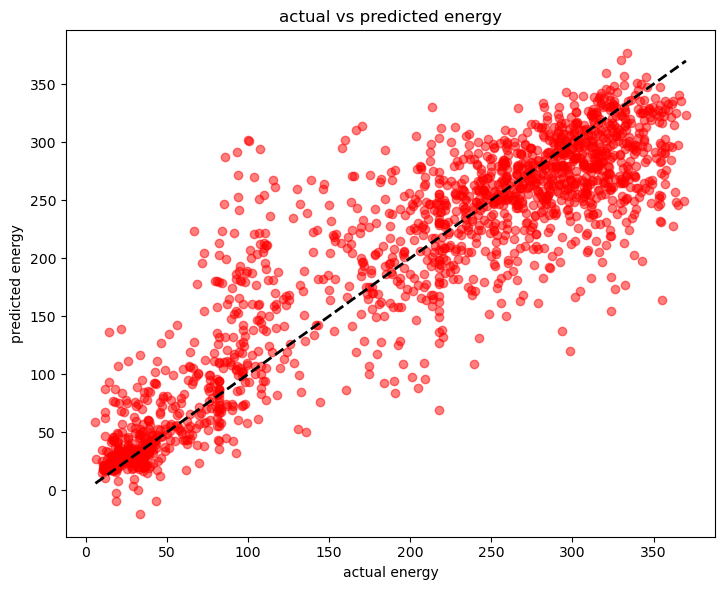

In [66]:
X_train, X_test, y_train, y_test = train_test_split(data, target_feature, test_size=0.2, random_state=42)
model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])

model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
mse_energy = mean_squared_error(y_test, y_pred)
r2_energy = r2_score(y_test, y_pred)
mae_energy = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse_energy}, R2: {r2_energy}, MAE: {mae_energy}')

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred, color= 'red', alpha=0.5)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], 'k--', lw = 2)
plt.xlabel('actual energy')
plt.ylabel('predicted energy')
plt.title('actual vs predicted energy')
plt.tight_layout()
plt.show()